# Этап 1. Получение данных

Изучим данные, предоставленные сервисом для проекта.

In [1]:
# Импортируем необходимые библиотеки
# %%
from scipy import stats as st
import numpy as np
np.warnings.filterwarnings('ignore')
import pandas as pd
import pandas_profiling
import seaborn as sns
from datetime import datetime
import matplotlib.pylab as plt
%matplotlib inline
import math

Источник данных: https://www.kaggle.com/code/iliassekkaf/video-game-sales-eda/data?select=Video_Games_Sales_as_at_22_Dec_2016.csv

Сохраняем данные из файла в df и выводим несколько строк.

In [2]:
df = pd.read_csv('C:/Users/valentina.tikhova/Downloads/Video_Games_Sales_as_at_22_Dec_2016.csv/Video_Games_Sales_as_at_22_Dec_2016.csv')

Выведем общую информацию по данным с помощью библиотеки pandas_profiling, которая позволяет автоматизировать первичный анализ данных. Сгенерим интерактивные отчеты в формате HTML.

In [3]:
df.profile_report(title='Pandas Profiling Report', progress_bar=False).to_notebook_iframe()

В результате на входе получаем данные, состоящие из:
- 16 столбцов и 16719 строк
- 7 категорийных и 9 количественных показателей
- Нет дубликатов
- Порядка 17,5% пропущенных значений (больше всего в столбцах Rating, Developer, User_Count, User_Score, Critic_Count, Critic_Score)
- Судя по корреляции: 
    - региональные и глобальные продажи зависят друг от друга, а вот продажи в Японии "изолированы" от глобальных продаж и не имеют с ними связи. 
    - На объем продаж большее влияние имет оценка критиков, которая в свою очередь перекликается с мнением пользователей.
    - Жанр выпускаемой игры "диктуется" её рейтингом. 
    - Год релиза связан с платформой выпускаемой игры (прослеживается связь с историей развития самой платформы)
- Судя по разбросу данных:
    - в выборке доминируют две платформы PS2 и DS
    - есть выбросы по году релиза - указаны данные за 1980 гг, порядка 95% всех данных показывают 2015 год релиза
    - лидирует в выборке жанр Action (20.2%), Sport (14.0%), Misc (10.5%) и Role-Playing (9.0%)
    - Самый популярный паблишер - Electronic Arts, а заявленный рейтинг - E (23.9%)

Всего в датасете отсутствует порядка 12% данных (в названии игры, год релиза, жанре, оценке критиков и пользователей и рейтинге).

# Этап 2. Подготовка данных

Перед началом исследования необходимо подготовить данные:
- переименовать столбцы (привести к нижнему регистру);
- заменить пропуски по годам и оценкой играков флагом (999 и NaN соответственно);
- заменить типы данных на корректные (столбец с годом должен быть целочисленным типом; столбец с рейтингом пользователей должен быть float (как и рейтингь критиков; столбец с оценкой ESRB сделаем object).

Приводим названия столбцов к нижнему регистру.

In [4]:
df.columns = map(str.lower, df.columns)

In [5]:
df['year_of_release'] = df['year_of_release'].fillna(999)
df.loc[df['user_score'] == 'tbd', 'user_score'] = float('nan')

In [6]:
df['year_of_release'] = df['year_of_release'].astype('int')
df['user_score'] = df['user_score'].astype('float')
df['rating'] = df['rating'].astype('object')

Посмотрим на пропуски в данных:

In [7]:
plt.figure(figsize=(7,7))
sns.heatmap(df.isnull()).set_title('Анализ пропусков в данных', fontsize=16);

Пропуски в имени игры, на мой взгляд, допущены ошибочно. Всего два пропуска не сыграют роли - от них избавимся. То же самое с жанром (тем более, что это одни и те же строки, как показывает код ниже).

In [8]:
df[df['name'].isna()]

name platform  year_of_release genre              publisher  na_sales  \
659    NaN      GEN             1993   NaN  Acclaim Entertainment      1.78   
14246  NaN      GEN             1993   NaN  Acclaim Entertainment      0.00   

       eu_sales  jp_sales  other_sales  global_sales  critic_score  \
659        0.53      0.00         0.08          2.39           NaN   
14246      0.00      0.03         0.00          0.03           NaN   

       critic_count  user_score  user_count developer rating  
659             NaN         NaN         NaN       NaN    NaN  
14246           NaN         NaN         NaN       NaN    NaN

Если рейтинга нет, то логично предположить, что просто не проставили рейтинг. Заполнять тут пропуски не стоит, потому что любые искусственно-сгенерированные значения могут исказить результат теста. 

In [9]:
df.dropna(subset = ['name'],inplace = True)

Выделим суммарные продажи во всех регионах в отдельный столбец.

In [10]:
df['total_sales']=df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
df.head()

name platform  year_of_release         genre publisher  \
0                Wii Sports      Wii             2006        Sports  Nintendo   
1         Super Mario Bros.      NES             1985      Platform  Nintendo   
2            Mario Kart Wii      Wii             2008        Racing  Nintendo   
3         Wii Sports Resort      Wii             2009        Sports  Nintendo   
4  Pokemon Red/Pokemon Blue       GB             1996  Role-Playing  Nintendo   

   na_sales  eu_sales  jp_sales  other_sales  global_sales  critic_score  \
0     41.36     28.96      3.77         8.45         82.53          76.0   
1     29.08      3.58      6.81         0.77         40.24           NaN   
2     15.68     12.76      3.79         3.29         35.52          82.0   
3     15.61     10.93      3.28         2.95         32.77          80.0   
4     11.27      8.89     10.22         1.00         31.37           NaN   

   critic_count  user_score  user_count developer rating  total_sales  
0          51.0         8.0       322.0  Nintendo      E        82.54  
1           NaN         NaN         NaN       NaN    NaN        40.24  
2          73.0         8.3       709.0  Nintendo      E        35.52  
3          73.0         8.0       192.0  Nintendo      E        32.77  
4           NaN         NaN         NaN       NaN    NaN        31.38

Теперь есть все данные для начала анализа.

# Этап 3. Исследовательский анализ данных

Интересно, сколько игр выпускалось в разные годы?

In [11]:
count_games_by_year = df.pivot_table(index='year_of_release', 
                                     values='name', 
                                     aggfunc='count').reset_index()
count_games_by_year.columns = ('year_of_release','count_of_games')

count_games_by_year.plot(x='year_of_release', y='count_of_games', style = 'o', xlim=(1980,2017), figsize=(15,5))
plt.title('Количество игр по годам', fontsize=16);

269 игр выпущены не понятно когда (флаг '999'), а до 1990-х количество выпущенных игр не так уж велико.
    
С точки зрения истории, 1990-е годы были ознаменованы заметными инновациями в компьютерных играх (например, в 1994 году  Electronic Arts выпустили Need for Speed, которая позже породила самую успешную серию гоночных игр  в мире и одну из десяти самых успешных серий видеоигр в целом). 
    
Следующий пик всплеска выпуска пришелся на 2008 год (развитие мобильных видеоигр было подстегнуто появлением двух крупнейших магазинов App Store и Google Play.) Не смотря на то, что в мире 2008 год ассоциировался в мировым экономическим кризисом,  давно доказано, что чем хуже состояние экономики, тем больше денег люди расходуют на недорогие развлечения, к коим, отчасти, можно отнести и компьютерные игры.
    
Начиная с 2010 года, когда был представлен первый планшет IPad, сегмент игр для мобильных устройств начал расширяться. В связи с этим, начали падать продажи трационных компьютерных игр на приставках.
    
Думаю, целесообразно взять данные именно начиная с 1994 года.

In [12]:
data_analysis = df.query('year_of_release >= 1994')

Как менялась выручка по платформам?

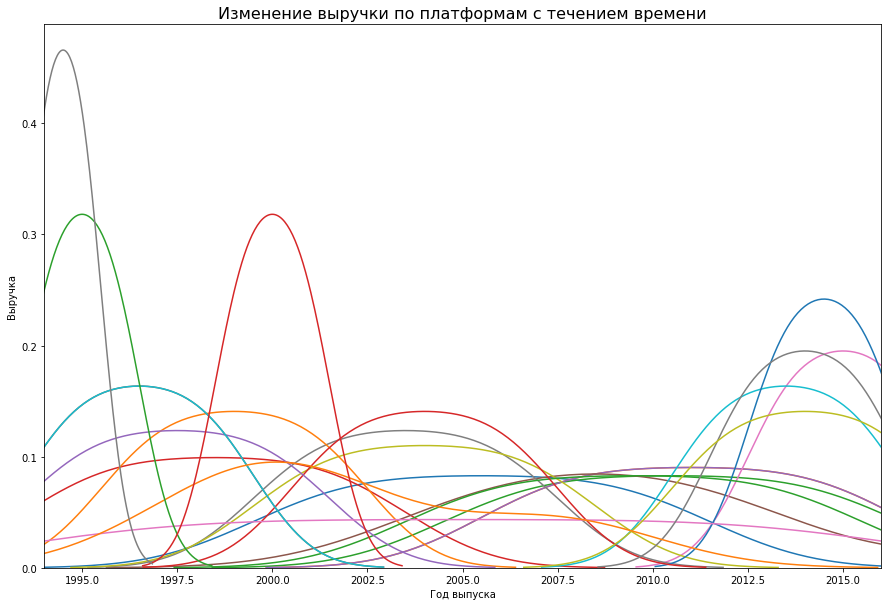

In [13]:
sales_by_platform_and_year = data_analysis.pivot_table(index=['platform','year_of_release'], 
                    values='total_sales', aggfunc='sum').reset_index().sort_values('total_sales', ascending = False)

fig, ax = plt.subplots(figsize=(15,10))
for platform in sales_by_platform_and_year['platform'].unique():
    sns.kdeplot(sales_by_platform_and_year[sales_by_platform_and_year['platform'] == platform]['year_of_release'], 
                label = platform)
plt.xlim(1994,2016)
plt.xlabel('Год выпуска')
plt.ylabel('Выручка')
plt.title('Изменение выручки по платформам с течением времени', fontsize=16);

Видно, что продажи менялись циклично: одни платформы переживали подъем, другие упадок. По графику можно отследить, что жизненный цикл платформы в среднем 10 лет.
Для последующего анализа целесообразно посмотреть суммарные продажи по платфомам и далее работать с топовыми (например, ТОП-6).

In [14]:
sales_by_platform = data_analysis.pivot_table(index='platform', values='total_sales', aggfunc='sum').reset_index().sort_values('total_sales', ascending = False)
sales_by_platform.query('total_sales > 700')

platform  total_sales
14      PS2      1233.56
26     X360       961.24
15      PS3       931.34
24      Wii       891.18
3        DS       803.05
13       PS       727.58

Посмотрим выручку по платформам из TOP-6.

In [15]:
list_top_platform = sales_by_platform.query('total_sales > 700')["platform"].tolist()
sales_top_platrofm = sales_by_platform_and_year.query('platform in @list_top_platform')

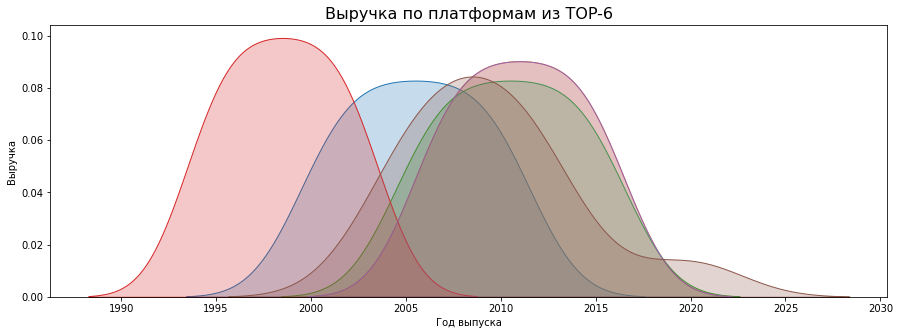

In [16]:
fig, ax = plt.subplots(figsize=(15,5))
for platform in sales_top_platrofm['platform'].unique():
    sns.kdeplot(sales_top_platrofm[sales_top_platrofm['platform'] == platform]['year_of_release'], label = platform, shade=True)
plt.xlabel('Год выпуска')
plt.ylabel('Выручка')
plt.title('Выручка по платформам из TOP-6', fontsize=16);

Тройка (PS, PS3, DS) появились на рынке почти одновременно и так же одновременно ушли с него. Сразу видно, что это были основные конкуренты на рынке компьютерных игр. PS2 был лидером на рынке долгое время (с конца 90-х до 2003 года). А вот Wii как один из ведущих игроков на рынке полностью ушли с рынка еще до 2010 года.

Для нашего исследования актуальный период - примерно половина среднего жизненнго цикла платформы (10 лет). Поэтому возьмем последние 5 лет (с 2012 по 2016 годы). А данные за предыдущие годы учитывать не будем.
    
Найдем самые прибыльные платформы за этот период.

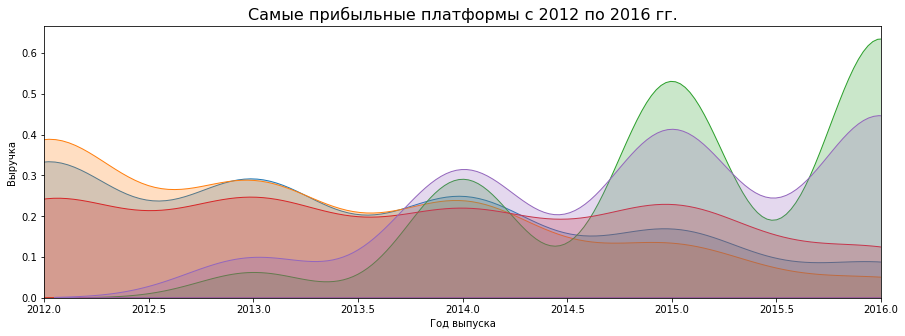

In [17]:
act_data = df.query('2012 <= year_of_release <= 2016')

act_top = act_data.pivot_table(index='platform', values='total_sales', 
                aggfunc='sum').reset_index().sort_values('total_sales', ascending = False).query(
                          'total_sales > 100')["platform"].tolist()
sales_act_top = act_data.query('platform in @act_top')

fig, ax = plt.subplots(figsize=(15,5))
for platform in sales_act_top['platform'].unique():
    sns.kdeplot(sales_act_top[sales_act_top['platform'] == platform]['year_of_release'], label = platform, shade=True)
plt.xlim(2012,2016)
plt.xlabel('Год выпуска')
plt.ylabel('Выручка')
plt.title('Самые прибыльные платформы с 2012 по 2016 гг.', fontsize=16);

Самые прибыльные платформы на графике вверху (ТОП-5): X360, 3DS, PS3 в основном были на одном уровне и держали высокую планку по  выручке в основном равномерно, без скачков. PS4 и XOne совпадают по периодам циклам, но PS4 почти всегда в прорыве по продажам.
   
Построим диаграммы размаха по глобальным продажам каждой игры и разбивкой по платформам.

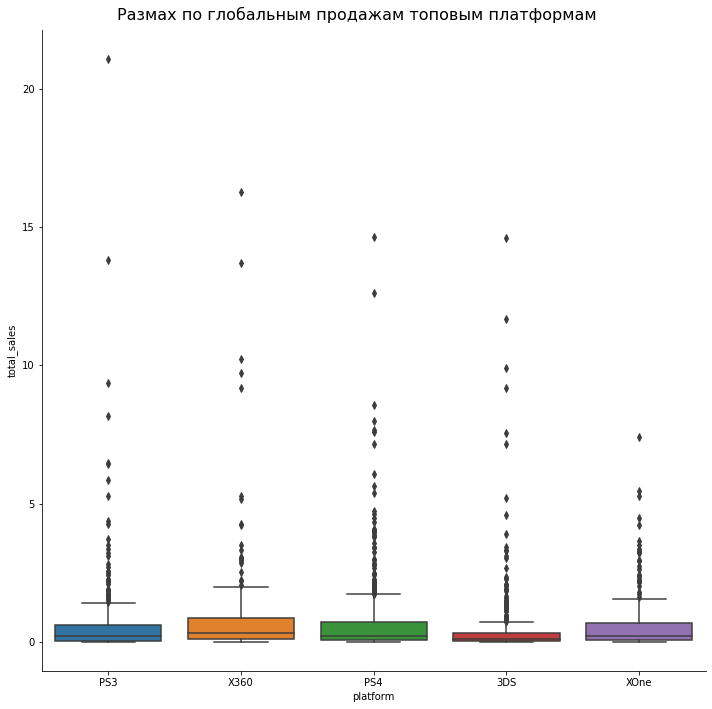

In [18]:
g = sns.catplot(x='platform', y='total_sales', data = sales_act_top, kind='box', height=10)
g.fig.suptitle('Размах по глобальным продажам топовым платформам', fontsize=16)
sales_act_top.groupby('platform')['total_sales'].describe().reset_index()
plt.tight_layout();

Видно, что большая часть выручки лежит в диапазоне до 1 млн. Есть выбросы, многие свыше 20 млн. Но при этом первый квартиль по каждой платфоре лежит ближе к нулю. Среднее значение почти в три раза по некоторым платформам больше медианы, это значит, что у диаграммы размаха длинный "ус". Средние продажи по платформам PS4 и X360 почти не различаются. 

Интересно, как влияют на продажи внутри одной платформы (возьмем, PS4 как лидера продаж) отзовы пользователей и критиков? Построим диаграмму рассеяния и посмотрим коррекляцию между отзывами и продажами.

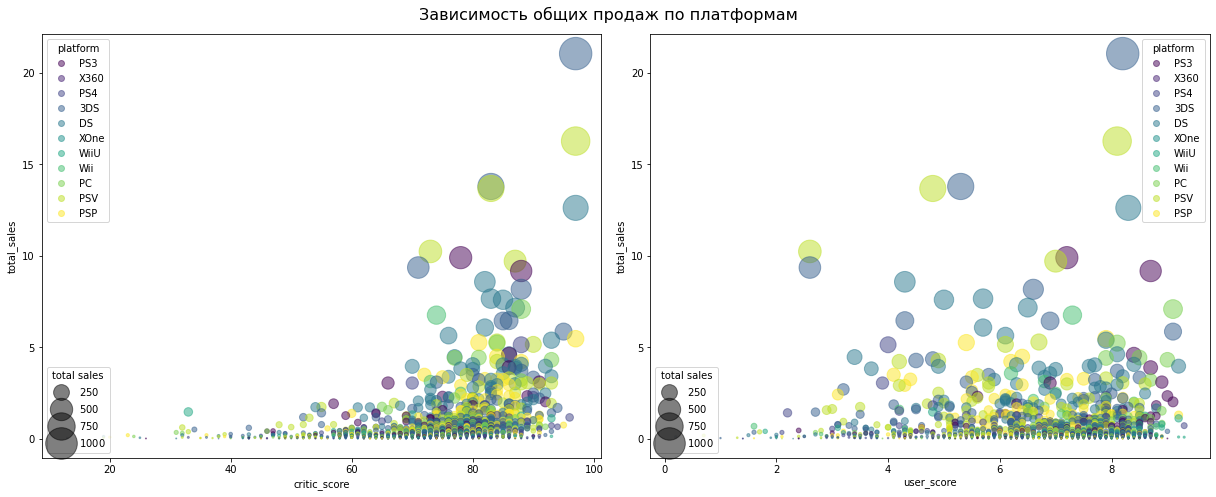

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7))
fig.suptitle('Зависимость общих продаж по платформам', fontsize=16)
score = ('critic_score', 'user_score')
s = act_data.total_sales*50                        # размер маркера покажет суммарную выручку
c = act_data.platform.astype('category').cat.codes # цвет маркета покажет платформу

for col in score:
    axes = ax[score.index(col)]
    g = axes.scatter(x = act_data[col], 
                    y = act_data.total_sales,
                    alpha = 0.5, 
                    s = s,
                    c = c)
    axes.set_xlabel(col)
    axes.set_ylabel('total_sales')
    legend1 = axes.legend(handles = g.legend_elements()[0], title="platform", labels=act_data.platform.unique().tolist())
    axes.add_artist(legend1)
    legend2 = axes.legend(*g.legend_elements("sizes", num=5), loc = 3, title="total sales") 

fig.tight_layout();

Конечно, количество продаж больше тех игр, чьи рейтинги критиков и пользователей выше, но размер продаж от этого почти не зависит. Если говорить про оценку критиков, то размер продаж выше, если оценка от 50 баллов. Что касается, оценок пользователей - то это совсем не надежный критерий оценки "стоимости" игры.

Независимость оценки пользователя и размера выручки от продажи игры подтверждается коэф.корреляции по платформам. Зависимость рейтинга критиков совсем незначительная.

Как распределяются игры по жанрам?

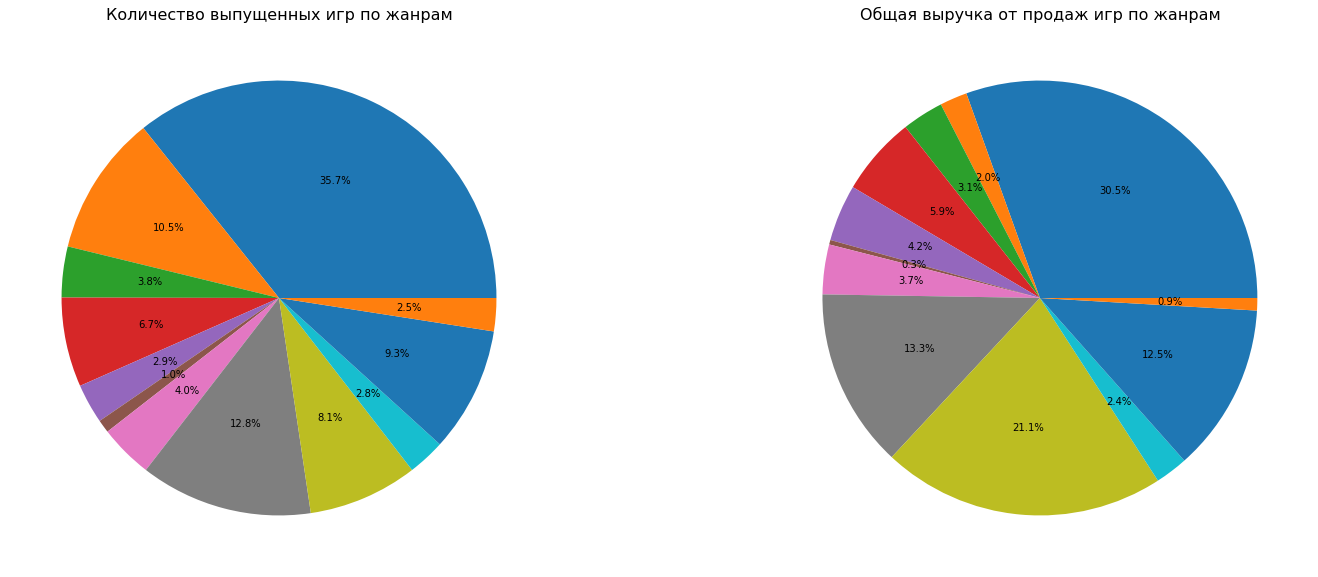

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10))
axs[0].pie(act_data.groupby('genre')['total_sales'].count(), autopct='%1.1f%%')
axs[0].set_title('Количество выпущенных игр по жанрам', fontsize=16)
axs[1].pie(act_data.groupby('genre')['total_sales'].sum(),  autopct='%1.1f%%')
axs[1].set_title('Общая выручка от продаж игр по жанрам', fontsize=16);

Распределение по количеству выпускаемых игр и полученной выручки от продаж по платформам почти совпадает: самая популярные игры в жанре Action, Shooter, Role-Plaing и Sprots, а самые низкие продажи у игр в жанре Fighting, Simulation, Adventure, Straregy и Puzzle.

# Этап 4. Портрет пользователя каждого региона

Для каждого региона определим: самые популярные платформы, жанры (топ-5), влияет ли рейтинг ESRB на продажи.

In [21]:
def top_by_reg(column, title):
    regions = ['na_sales', 'eu_sales', 'jp_sales']
    fig, axs = plt.subplots(1, len(regions), figsize=(25, 10), sharey=True)
    fig.suptitle(title)
    
    for reg in regions:
        top5 = act_data.groupby(column)[reg].sum().sort_values(ascending = False).head()
        axs[regions.index(reg)].pie(top5.values, 
                               labels = top5.index,
                               autopct='%1.2f%%')
        axs[regions.index(reg)].set_title('TOP-5 по ' + str(reg[0:2]).upper(), fontsize=16)

Самые популярные платформы по регонам.

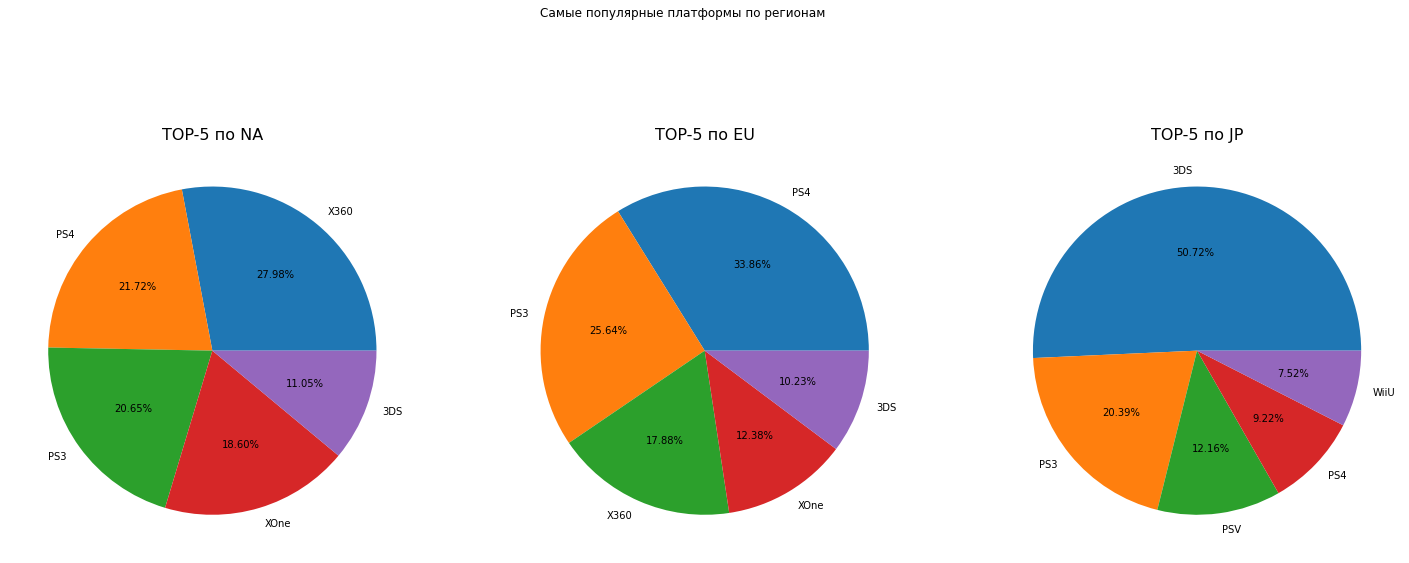

In [22]:
top_by_reg('platform', 'Самые популярные платформы по регионам')

Самые популярные жанры по регионам.

In [23]:
top_by_reg('genre', 'Самые популярные жанры по регионам')

Рейтинги по регионам.

In [24]:
sns.set_theme(style="ticks")
g = sns.catplot(data = act_data[['na_sales', 'eu_sales', 'jp_sales', 'rating']].melt(['rating']), 
            x="value", 
            y='variable', 
            hue = 'rating', 
            orient="h",
            kind='box',
            height=12)   
g.fig.suptitle('Рейтинги по регионам', fontsize=16)   
g.set(xlabel = None, ylabel = None) 
fig.tight_layout();


Top5 платформ по регионам:
   - для Европы:           PS4 (33,9%), PS3 (25,6%), X360 (17,9%), XOne (12,4%), 3DS (10,2%)
   - для Японии:           3DS (50,7%), PS3 (20,4%), PSV (12,2%),  PS4 (9,2%),   WiiU (7,5%)
   - для Северной Америки: X360 (28%),  PS4 (21,7%), PS3 (20,7%),  XOne (18,6%), 3DS (11%)

Top5 жанров по регионам:
   - для Европы: Action (38,1%),  Shooter (27,2%), Sports (16,5%),  Role-Playing (11,6%), Racing (6,5%)
   - для Японии:           Role-Playing (43,3%), Action (35%), Misc (8,5%),  Simulation (6,9%),   Fighting (6,3%)
   - для Северной Америки: Action (35,1%),  Shooter (28,6%), Sports (16,1%),  Role-Playing (12,6%), Misc (7,5%)

Зависимость рейтинга на продажи:
    - для Европы: M, E10+, E, T
    - для Японии: T, M, E, E10+
    - для Северной Америки: M, E10+, E, T

Для Европы и Северной Америки зависимость продаж от рейтинга совпадает: больше всего играков в возрасте от 17 лет, далее идут лица старше 10 лет, далее игры без орагничений по возрасту и напоследок игры для людей, старше 13. 

А вот в Японии большая популярность компьютерных игр среди 13-летних, далее 17 летние, игры без ограничении по возрасту и от 10 лет.

# Этап 5. Проверка гипотезы

Проверим, одинаковые ли средние пользовательские рейтинги платформ XboxOne и PC (гипотеза H0).

In [25]:
XOne_mean_user_score = act_data.query('platform == "XOne"')['user_score'].fillna(0)
PC_mean_user_score = act_data.query('platform == "PC"')['user_score'].fillna(0)

# Критический уровень статистической значимости. Если p-value будет меньше него, нужно отвергнуть гипотезу
alpha = 0.05 

# Проверка гипотезы о равенстве средних двух совокупностей
results = st.ttest_ind(PC_mean_user_score, XOne_mean_user_score)    

print('p-значение:', round(results.pvalue,5))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.06798
Не получилось отвергнуть нулевую гипотезу


Не получилось опровергнуть нулевую гипотезу. Хоть полученные средние пользовательские рейтинги и не одинаковы, с вероятностью почти 7% такое различие можно получить случайно.

Проверим, разные ли средние пользовательские рейтинги жанров Action и Sports

In [26]:
Action_mean_user_score = act_data.query('genre == "Action"')['user_score'].fillna(0)
Sports_mean_user_score = act_data.query('genre == "Sports"')['user_score'].fillna(0)

# Критический уровень статистической значимости. Если p-value будет меньше него, нужно отвергнуть гипотезу
alpha = 0.05 

# Проверка гипотезы о НЕравенстве средних двух совокупностей
results = st.ttest_ind(Action_mean_user_score, Sports_mean_user_score)    

print('p-значение:', round(results.pvalue,5))
if results.pvalue > alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.03053
Не получилось отвергнуть нулевую гипотезу


Не получилось опровергнуть нулевую гипотезу. Пользовательские рейтинги этих двух жанров разные. Если посмотреть выборку по жанрам, кажется, что по Action оценки выше.

# Этап 6. Общий вывод

Анализируя полученные на входе данные, можно увидеть, как с течением времени увеличивается релиз новых компьютерных игр и платформ.
В 90-х инновации в сфере технологий позволили выпустить серии популярных компьютерных игр, в 2008 году создание двух крупнейших магазинов приложений также подстегнуло производителей компьютерных игр увеличить свои продажи. Начиная с 2010 года выручка от компьютерных игр уменьшается из-за популярности мобильных устройств, что выдвигает игровые приставки на второе место.

Жизненный цикл платформ составляет примерно 10 лет: от создания первых игр, их развитием, роста популярности, пика платформы на рынке, упадку и наконец ухода с рынка.

Для планирования рекламной кампании целесообразно брасть в расчет данные за последние 5 лет и выделить в них топовые платформы и жанры.

Важно понимать, как влияют рейтинги критиков и пользователей на продажи игр. Интересно узнать, что размер продаж выше, если оценка критика от 50 баллов. Что касается, оценок пользователей - то это совсем не надежный критерий оценки "стоимости" игры.

Распределение по количеству выпускаемых игр и полученной выручки от продаж по платформам почти совпадает: самая популярные игры в жанре Action, Shooter, Role-Plaing и Sprots, а самые низкие продажи у игр в жанре Fighting, Simulation, Adventure, Straregy и Puzzle.

Портрет пользователя Северной Америки и Европы почти совпадает: пользователям нравятся игры в стиле Action, Shooter, Sports и Role-playing, при этом для игры они используют одни и те же платформы. Игры больше всего популярны у людей старше 17 лет, а меньше всего интересуются играми 13-летние.

Иной профиль у пользователя из Японии: в его рейтинге значатся такие жанры как Misc, Simulation и Fighting. При выборе платформ он так же выбирает WiiU и PSV. Играков больше всего в возрасте от 13 лет, а меньше всего сидят за игровыми приставками дети от 10 лет.

Пользовательские рейтинги в среднем по платформам XboxOne и PC одинаковы, а вот жанров Action и Sports - наоборот.

Все эти факты правильно будет учитывать при создании рекламных кампаний при раскрутке новых платформ\игр\жанров, а также для поддержания рейтинга старых.